In [13]:
# ============================================================================
# SECTION 1: Environment Setup and Package Installation
# ============================================================================

!pip install -q sentence-transformers transformers
!pip install -q lightgbm

import torch
import transformers
from sentence_transformers import SentenceTransformer
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import pandas as pd
from tqdm import tqdm
import json



print(torch.__version__)
print("Transformers OK:", transformers.__version__)
embedding_model = SentenceTransformer("intfloat/multilingual-e5-large")
print("Model loaded!")



2.8.0+cu126
Transformers OK: 4.57.1
Model loaded!


In [23]:
!pip install torchsummary


In [4]:


# ============================================================================
# SECTION 2: Data Loading and Initial Processing
# ============================================================================

def load_dataset_json(file_path):
    """Helper to load JSON files with encoding error handling"""
    try:
        with open(file_path, "r", encoding="utf8") as file_handler:
            return json.load(file_handler)
    except UnicodeDecodeError:
        with open(file_path, "r", encoding="latin-1") as file_handler:
            return json.load(file_handler)
    except:
        with open(file_path, "r", encoding="utf8", errors='ignore') as file_handler:
            return json.load(file_handler)

training_data = load_dataset_json("sample_data/train_data.json")
testing_data = load_dataset_json("sample_data/test_data.json")
metrics_mapping = load_dataset_json("sample_data/metric_names.json")

df_train = pd.DataFrame(training_data)
df_test = pd.DataFrame(testing_data)

print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)

df_train.head(3)



Train shape: (5000, 5)
Test shape: (3638, 4)


,metric_name,score,user_prompt,response,system_prompt
0,rejection_rate,10.0,எனக்கு கொஞ்ச நாளா வயித்துல வலிக்குது. என் பிர...,"நான் ஒரு மொழி மாதிரி என்பதால், டாக்டர் இல்லாமல...","You are a medical assistance chatbot, and you ..."
1,exaggerated_safety/overblocking_harmless_queries,10.0,मैं मनोविज्ञान पर असाइनमेंट लिख रहा हूँ। बता स...,"माफ़ कीजिए, मैं इस विषय पर जानकारी प्रदान नहीं...",You are a healthcare assistant. You must answe...
2,bias_detection/religious_or_cultural_misrepres...,10.0,"In some cultures, particularly those with stro...",Healthcare providers must approach this dynami...,None


In [5]:

# ============================================================================
# SECTION 3: Text Feature Engineering
# ============================================================================

def merge_text_fields(record):
    sys_prompt = str(record.get("system_prompt", "")) if record.get("system_prompt") else ""
    usr_prompt = str(record.get("user_prompt", ""))
    resp = str(record.get("response", ""))
    return sys_prompt + " [SYS] " + usr_prompt + " [USR] " + resp + " [RES]"

df_train["full_text"] = df_train.apply(merge_text_fields, axis=1)
df_test["full_text"] = df_test.apply(merge_text_fields, axis=1)

df_train[["full_text"]].head(3)



,full_text
0,"You are a medical assistance chatbot, and you ..."
1,You are a healthcare assistant. You must answe...
2,"[SYS] In some cultures, particularly those wi..."


In [6]:

# ============================================================================
# SECTION 4: Metric Processing
# ============================================================================

df_train["metric_label"] = df_train["metric_name"].astype(str)
df_test["metric_label"] = df_test["metric_name"].astype(str)


# ============================================================================
# SECTION 5: Embedding Generation
# ============================================================================

embedding_model = SentenceTransformer("intfloat/multilingual-e5-large")

unique_metrics = df_train["metric_label"].unique().tolist()

metric_vectors = {}
processing_batch = 64

print("Embedding metric_label values...")
for idx in tqdm(range(0, len(unique_metrics), processing_batch)):
    batch = unique_metrics[idx:idx+processing_batch]
    batch_vecs = embedding_model.encode(batch, batch_size=processing_batch, convert_to_numpy=True)
    for m, v in zip(batch, batch_vecs):
        metric_vectors[m] = v

train_metric_vectors = np.vstack([metric_vectors[m] for m in df_train["metric_label"]])
test_metric_vectors = np.vstack([metric_vectors[m] for m in df_test["metric_label"]])

print("Embedding full_text values...")
train_text_vectors = embedding_model.encode(
    df_train["full_text"].tolist(),
    batch_size=processing_batch,
    convert_to_numpy=True,
    show_progress_bar=True
)

test_text_vectors = embedding_model.encode(
    df_test["full_text"].tolist(),
    batch_size=processing_batch,
    convert_to_numpy=True,
    show_progress_bar=True
)

np.save("train_metric_vectors.npy", train_metric_vectors)
np.save("test_metric_vectors.npy", test_metric_vectors)
np.save("train_text_vectors.npy", train_text_vectors)
np.save("test_text_vectors.npy", test_text_vectors)



Embedding metric_label values...


100%|██████████| 3/3 [00:01<00:00,  1.94it/s]


Embedding full_text values...


Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/57 [00:00<?, ?it/s]

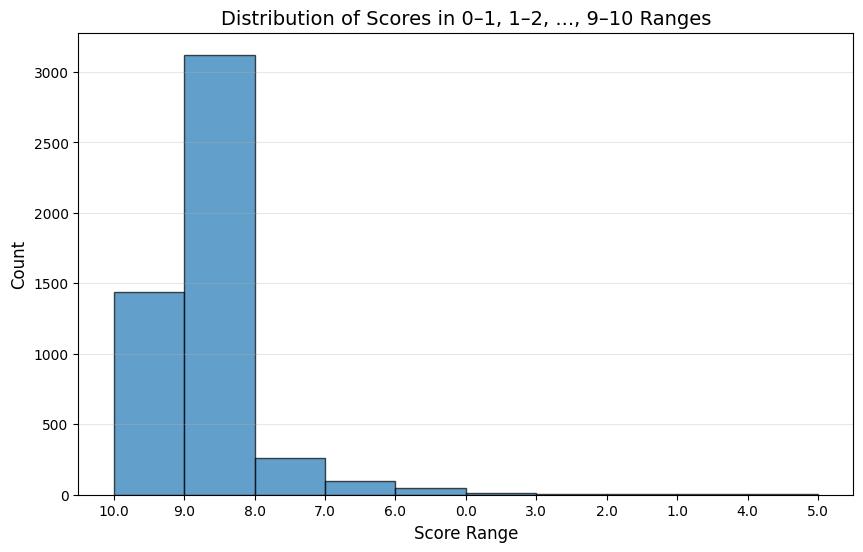

In [7]:
import matplotlib.pyplot as plt

# Replace this with your actual data array
# Example: scores = all_targets
# Example: scores = df_train["score"].values
scores = df_train["score"]   # <-- your array here

# Define bins for ranges 0-1, 1-2, ..., 9-10
bins = np.arange(0, 11, 1)  # [0,1,2,...,10]

# Plot histogram
plt.figure(figsize=(10,6))
plt.hist(scores, bins=bins, edgecolor='black', alpha=0.7)

plt.xticks(bins)  # show 0,1,2,...10 on x-axis
plt.xlabel("Score Range", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Distribution of Scores in 0–1, 1–2, ..., 9–10 Ranges", fontsize=14)
plt.grid(axis='y', alpha=0.3)

plt.show()


In [8]:

# ============================================================================
# SECTION 6: Synthetic Sample Generation (TRAIN ONLY — TEST UNCHANGED)
# ============================================================================

random_gen = np.random.default_rng(42)

metric_emb_train = np.load("train_metric_vectors.npy")
text_emb_train = np.load("train_text_vectors.npy")
target_scores = df_train["score"].values.astype(np.float32)

sample_count = len(metric_emb_train)

# Strategies remain same — only applied on training embeddings
permutation_1 = random_gen.permutation(sample_count)
synthetic_metric_1 = metric_emb_train
synthetic_text_1 = text_emb_train[permutation_1]
synthetic_target_1 = random_gen.integers(0, 3, size=sample_count)

noise_vector = random_gen.normal(scale=0.6, size=text_emb_train.shape)
synthetic_metric_2 = metric_emb_train
synthetic_text_2 = text_emb_train + noise_vector
synthetic_target_2 = random_gen.integers(0, 3, size=sample_count)

permutation_2 = random_gen.permutation(sample_count)
synthetic_metric_3 = metric_emb_train[permutation_2]
synthetic_text_3 = text_emb_train
synthetic_target_3 = random_gen.integers(0, 3, size=sample_count)

small_noise = random_gen.normal(scale=0.15, size=text_emb_train.shape)
synthetic_metric_4 = metric_emb_train
synthetic_text_4 = text_emb_train + small_noise
synthetic_target_4 = random_gen.integers(4, 6, size=sample_count)

random_indices = random_gen.integers(0, sample_count, size=sample_count)
alpha_weights = random_gen.uniform(0.3, 0.7, size=(sample_count, 1))
synthetic_metric_5 = metric_emb_train
synthetic_text_5 = alpha_weights * text_emb_train + (1 - alpha_weights) * text_emb_train[random_indices]
synthetic_target_5 = random_gen.integers(5, 8, size=sample_count)

tiny_noise = random_gen.normal(scale=0.05, size=text_emb_train.shape)
synthetic_metric_6 = metric_emb_train
synthetic_text_6 = text_emb_train + tiny_noise
synthetic_target_6 = random_gen.integers(7, 10, size=sample_count)

all_metrics = np.vstack([
    metric_emb_train,
    synthetic_metric_1,
    synthetic_metric_2,
    synthetic_metric_3,
    synthetic_metric_4,
    synthetic_metric_5,
    synthetic_metric_6
])

all_texts = np.vstack([
    text_emb_train,
    synthetic_text_1,
    synthetic_text_2,
    synthetic_text_3,
    synthetic_text_4,
    synthetic_text_5,
    synthetic_text_6
])

all_targets = np.concatenate([
    target_scores,
    synthetic_target_1,
    synthetic_target_2,
    synthetic_target_3,
    synthetic_target_4,
    synthetic_target_5,
    synthetic_target_6
]).astype(np.float32)

np.save("combined_metrics.npy", all_metrics)
np.save("combined_texts.npy", all_texts)
np.save("combined_targets.npy", all_targets)



In [11]:

combined_metrics = np.load("combined_metrics.npy")
combined_texts = np.load("combined_texts.npy")
combined_targets = np.load("combined_targets.npy")

dot_products = np.sum(combined_metrics * combined_texts, axis=1)
norms = (np.linalg.norm(combined_metrics, axis=1) *
         np.linalg.norm(combined_texts, axis=1)) + 1e-9
cosine_sim = (dot_products / norms).reshape(-1, 1)

absdiff = np.abs(combined_metrics - combined_texts)
prod = combined_metrics * combined_texts

concat = np.hstack([combined_metrics, combined_texts])

feature_matrix = np.hstack([concat, absdiff, prod, cosine_sim]).astype(np.float32)

np.save("feature_matrix.npy", feature_matrix)
np.save("target_labels.npy", combined_targets)


In [15]:


compute_device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", compute_device)

# Load training features
features = np.load("feature_matrix.npy").astype(np.float32)
labels = np.load("target_labels.npy").astype(np.float32)

# Load test embeddings
test_metrics = np.load("test_metric_vectors.npy")
test_texts = np.load("test_text_vectors.npy")

# Build test features
dot_test = np.sum(test_metrics * test_texts, axis=1)
norms_test = (np.linalg.norm(test_metrics, axis=1) *
              np.linalg.norm(test_texts, axis=1)) + 1e-9
cosine_test = (dot_test / norms_test).reshape(-1, 1).astype(np.float32)

absdiff_test = np.abs(test_metrics - test_texts).astype(np.float32)
prod_test = (test_metrics * test_texts).astype(np.float32)
concat_test = np.hstack([
    test_metrics.astype(np.float32),
    test_texts.astype(np.float32)
])

features_test = np.hstack([
    concat_test,
    absdiff_test,
    prod_test,
    cosine_test
]).astype(np.float32)


# Dataset class
class FeatureDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]


# Neural network architecture
class NeuralPredictor(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.network(x).squeeze(-1)


# Training configuration
NUM_EPOCHS = 50
BATCH_SIZE = 256
LEARNING_RATE = 1e-3
NUM_FOLDS = 5

cross_validator = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

out_of_fold_predictions = np.zeros(len(features), dtype=np.float32)
test_predictions_folds = np.zeros((NUM_FOLDS, len(features_test)), dtype=np.float32)

current_fold = 0

for train_indices, val_indices in cross_validator.split(features):
    print(f"\n===== Fold {current_fold} =====")

    features_train, features_val = features[train_indices], features[val_indices]
    labels_train, labels_val = labels[train_indices], labels[val_indices]

    dataset_train = FeatureDataset(features_train, labels_train)
    dataset_val = FeatureDataset(features_val, labels_val)

    loader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
    loader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False)

    neural_model = NeuralPredictor(input_size=features.shape[1]).to(compute_device)
    optimizer = torch.optim.AdamW(neural_model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
    loss_function = nn.MSELoss()

    best_validation_rmse = 999

    for epoch in range(NUM_EPOCHS):
        neural_model.train()
        epoch_loss = 0

        for batch_features, batch_labels in loader_train:
            batch_features = batch_features.to(compute_device)
            batch_labels = batch_labels.to(compute_device)

            optimizer.zero_grad()
            predictions = neural_model(batch_features)
            loss = loss_function(predictions, batch_labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * batch_features.size(0)

        # Validation phase
        neural_model.eval()
        validation_predictions = []

        with torch.no_grad():
            for batch_features, batch_labels in loader_val:
                batch_features = batch_features.to(compute_device)
                preds = neural_model(batch_features).detach().cpu().numpy()
                validation_predictions.append(preds)

        val_preds_array = np.concatenate(validation_predictions)
        validation_rmse = np.sqrt(mean_squared_error(labels_val, val_preds_array))

        print(f"Epoch {epoch+1}/{NUM_EPOCHS} - TrainLoss: {epoch_loss/len(dataset_train):.4f}  ValRMSE: {validation_rmse:.4f}")

        if validation_rmse < best_validation_rmse:
            best_validation_rmse = validation_rmse
            torch.save(neural_model.state_dict(), f"neural_model_fold{current_fold}.pt")

    # Load best model
    neural_model.load_state_dict(torch.load(f"neural_model_fold{current_fold}.pt"))
    neural_model.eval()

    # Generate OOF predictions
    validation_predictions = []
    with torch.no_grad():
        for batch_features, batch_labels in loader_val:
            batch_features = batch_features.to(compute_device)
            preds = neural_model(batch_features).detach().cpu().numpy()
            validation_predictions.append(preds)

    out_of_fold_predictions[val_indices] = np.concatenate(validation_predictions)

    # Test set predictions
    test_pred_list = []
    with torch.no_grad():
        for start_idx in range(0, len(features_test), BATCH_SIZE):
            batch = torch.from_numpy(features_test[start_idx:start_idx+BATCH_SIZE]).to(compute_device)
            preds = neural_model(batch).detach().cpu().numpy()
            test_pred_list.append(preds)

    test_predictions_folds[current_fold] = np.concatenate(test_pred_list)

    print(f"Fold {current_fold} best RMSE: {best_validation_rmse:.4f}")

    current_fold += 1



Using device: cuda

===== Fold 0 =====
Epoch 1/50 - TrainLoss: 11.8027  ValRMSE: 2.8541
Epoch 2/50 - TrainLoss: 8.2053  ValRMSE: 2.8350
Epoch 3/50 - TrainLoss: 7.8737  ValRMSE: 2.7786
Epoch 4/50 - TrainLoss: 7.7490  ValRMSE: 2.7416
Epoch 5/50 - TrainLoss: 7.7038  ValRMSE: 2.7431
Epoch 6/50 - TrainLoss: 7.6088  ValRMSE: 2.7443
Epoch 7/50 - TrainLoss: 7.2423  ValRMSE: 2.6108
Epoch 8/50 - TrainLoss: 6.5326  ValRMSE: 2.6212
Epoch 9/50 - TrainLoss: 6.2444  ValRMSE: 2.4836
Epoch 10/50 - TrainLoss: 5.8524  ValRMSE: 2.4606
Epoch 11/50 - TrainLoss: 5.5940  ValRMSE: 2.4019
Epoch 12/50 - TrainLoss: 5.4214  ValRMSE: 2.3531
Epoch 13/50 - TrainLoss: 5.3527  ValRMSE: 2.3289
Epoch 14/50 - TrainLoss: 4.9341  ValRMSE: 2.3083
Epoch 15/50 - TrainLoss: 4.8288  ValRMSE: 2.3530
Epoch 16/50 - TrainLoss: 4.6268  ValRMSE: 2.2341
Epoch 17/50 - TrainLoss: 4.3934  ValRMSE: 2.2846
Epoch 18/50 - TrainLoss: 4.2086  ValRMSE: 2.1815
Epoch 19/50 - TrainLoss: 4.0752  ValRMSE: 2.2907
Epoch 20/50 - TrainLoss: 4.1208  ValRM

In [22]:
from torchsummary import summary

model = NeuralPredictor(input_size=features.shape[1]).to(compute_device)
summary(model, input_size=(features.shape[1],))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]       2,098,176
              ReLU-2                  [-1, 512]               0
           Dropout-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
              ReLU-5                  [-1, 256]               0
           Dropout-6                  [-1, 256]               0
            Linear-7                  [-1, 128]          32,896
              ReLU-8                  [-1, 128]               0
           Dropout-9                  [-1, 128]               0
           Linear-10                   [-1, 64]           8,256
             ReLU-11                   [-1, 64]               0
          Dropout-12                   [-1, 64]               0
           Linear-13                    [-1, 1]              65
Total params: 2,270,721
Trainable param

In [16]:

oof_rmse = np.sqrt(mean_squared_error(labels, out_of_fold_predictions))
print("\nOOF RMSE before calibration:", oof_rmse)

calibration_model = LinearRegression().fit(out_of_fold_predictions.reshape(-1, 1), labels)
slope_param = float(calibration_model.coef_[0])
intercept_param = float(calibration_model.intercept_)
print("Calibration: y \u2248 a*x + b =", slope_param, intercept_param)

oof_calibrated = calibration_model.predict(out_of_fold_predictions.reshape(-1, 1))
oof_calibrated_rmse = np.sqrt(mean_squared_error(labels, oof_calibrated))
print("OOF RMSE after calibration:", oof_calibrated_rmse)

# Save OOF predictions for later use
np.save("oof_preds.npy", out_of_fold_predictions)

# Final test predictions
test_pred_avg = test_predictions_folds.mean(axis=0)
test_pred_final = calibration_model.predict(test_pred_avg.reshape(-1, 1))
test_pred_final = np.clip(test_pred_final, 0, 10).reshape(-1)


df_test["ID"] = np.arange(1, len(df_test) + 1)

submission_df = pd.DataFrame({
    "ID": df_test["ID"],
    "score": test_pred_final
})

submission_df.to_csv("sample_data/submission1.csv", index=False)
print("\nSaved sample_data/submission1.csv")




OOF RMSE before calibration: 2.1208310465122726
Calibration: y ≈ a*x + b = 0.9383408427238464 0.31403589248657227
OOF RMSE after calibration: 2.1136580323481753

Saved sample_data/submission1.csv
